In [287]:
from BaroSphere import BaroSphere
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
plt.style.use('dark_background')
B=BaroSphere(
    ntrunc=63,
    dt=1800,
    damping_order=2,
    efold=6*3600
)

/home/rfajber/code/Barotropic/BaroSphere.py:77: RuntimeWarning: invalid value encountered in true_divide
  self.w_indxm_damp=self.indxm/self.indxm


In [292]:
#total number of steps to take
Nsteps = int(100*24*3600/B.dt)
#how often to take snapshots
dN_snap = int(6*3600/B.dt)
#total number of snapshots
Nsnaps = int(Nsteps/dN_snap)

print(Nsteps,dN_snap,Nsnaps)

#first time step 
vrt0 = 0*B.vrtg_unstable_jet(m=12,A=8e-5) #initialiae with 0 
vrt1 = vrt0 + B.dt * B.vrt_time_tendency(vrt0)

B.vrtg_m1 = vrt0
B.vrtg = vrt0

#initialize the snapshots
vrt = np.zeros([Nsnaps+1,B.nlat,B.nlon])
vrt[0] = vrt0
ksnap = 1

#stocahstic realization decay time scale
tau=2*3600*24
#noise strength
NS=1.e-10

#damping timescale for the mean drag
tdamp=10*24*3600

#spectral filter for the noise realization
B.w_indxm_damp = np.ones(len(B.indxm))
B.w_indxm_damp[B.indxm>20] = 0
B.w_indxm_damp[B.indxm<14] = 0

#noise realization container
W = np.zeros(len(B.w_indxm_damp))
#sine of latitude
s=np.sin(B.lats*B.a)
#grid space filter
damping_window=np.exp( - np.power( (s - 0.7) / 0.15 ,2) )


#main time loop
for i in range(1,Nsteps+1):
    #timestep the model
    B.RA_leapfrog()
    #time step the noise realization
    W = (1-B.dt/tau) * W + NS*np.sqrt(B.dt / (2 * tau) )*np.random.randn(len(W))
    #add the noise to the model spectrally
    B.vrtg += B.x.spectogrd(B.w_indxm_damp * W * B.dt) * damping_window    
    #apply mean "drag" to the model
    B.vrtg = B.vrtg * tdamp / (tdamp + B.dt)

    #store data sometimes
    if i%dN_snap == 0:
        vrt[ksnap] = np.copy(B.vrtg)
        print(i,i*B.dt/3600/24,ksnap,np.max(vrt[ksnap]))
        ksnap += 1


4800 12 400
12 0.25 1 1.2319577008818824e-05
24 0.5 2 2.2645052130336015e-05
36 0.75 3 3.508218925198436e-05
48 1.0 4 4.113652417145809e-05
60 1.25 5 4.562044302253304e-05
72 1.5 6 5.553101248489286e-05
84 1.75 7 6.764436919017542e-05
96 2.0 8 7.603221172137716e-05
108 2.25 9 8.032607832408496e-05
120 2.5 10 8.53134196236141e-05
132 2.75 11 9.747722821228841e-05
144 3.0 12 0.00010272245970312622
156 3.25 13 0.00010653796824558856
168 3.5 14 0.00011163949337158654
180 3.75 15 0.00011079872545946909
192 4.0 16 0.00011302613781033211
204 4.25 17 0.00011972242457068016
216 4.5 18 0.00011781170788044865
228 4.75 19 0.00011645764278987589
240 5.0 20 0.00012524186860065202
252 5.25 21 0.00012384697585802315
264 5.5 22 0.00013927391801889127
276 5.75 23 0.00014382294474049565
288 6.0 24 0.00013880720633138241
300 6.25 25 0.000126098080300058
312 6.5 26 0.00012489740026189235
324 6.75 27 0.00011889227925414479
336 7.0 28 0.00012037205110979799
348 7.25 29 0.00011599893253800031
360 7.5 30 0.000

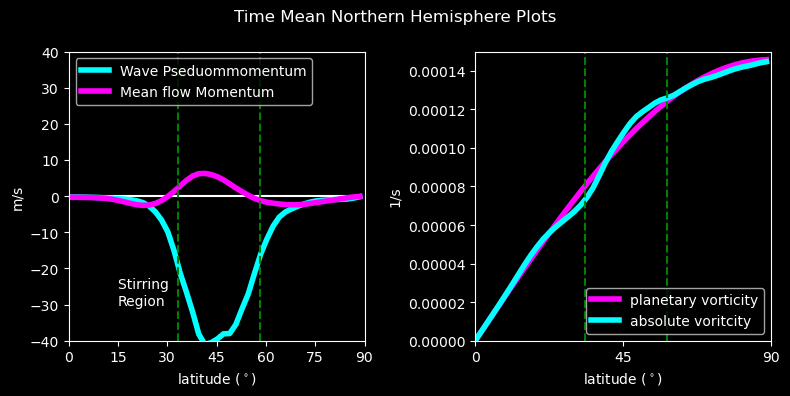

In [295]:
u,v=B.get_uv_vrtg(vrt[120:].mean(axis=0))

beta=B.omega*2*np.cos(np.pi/4)/B.rsphere

A=-np.power(vrt-vrt.mean(axis=-1)[:,:,np.newaxis],2)/(2*beta)
A=A[120:].mean(axis=0)

lw=4

plt.figure(0,figsize=(8,4))

plt.subplot(1,2,1)

plt.ylabel('m/s')
plt.xlabel('latitude ($^\\circ$)')
plt.xlim([0,90])
plt.plot(B.lats1,0*B.lats1,'w')
plt.xticks(np.linspace(0,90,7))
plt.plot(B.lats1,A.mean(axis=-1),label='Wave Pseduommomentum',
linewidth=lw,color='cyan',alpha=1,linestyle='-')
plt.plot(B.lats1,u.mean(axis=-1),label='Mean flow Momentum',
linewidth=lw,color='magenta',alpha=1,linestyle='-')
plt.legend(loc=2)
plt.ylim([-40,40])

plt.axvline(180/np.pi*np.arcsin(0.55),linestyle='--',color='green')
plt.axvline(180/np.pi*np.arcsin(0.85),linestyle='--',color='green')

plt.annotate('Stirring \nRegion',(15,-30),color='white')

#plt.gca().twinx()
#plt.plot(B.lats1,damping_window[:,0],'w--',label='Stirring Region')
#plt.ylabel('')

plt.legend(loc=2)

plt.subplot(1,2,2)

plt.ylabel('1/s')
plt.xlabel('latitude ($^\\circ$)')
plt.xticks(np.linspace(-90,90,5))
plt.plot(B.lats1,B.f.mean(axis=-1),
label='planetary vorticity',linewidth=lw,color='magenta')
plt.plot(B.lats1,B.f.mean(axis=-1)+vrt[20*4:].mean(axis=(0,-1)),
label='absolute voritcity',linewidth=lw,color='cyan')
plt.axvline(180/np.pi*np.arcsin(0.55),linestyle='--',color='green')
plt.axvline(180/np.pi*np.arcsin(0.85),linestyle='--',color='green')
plt.xlim([0,90])
plt.ylim([0.e-4,1.5e-4])
plt.legend()

plt.suptitle('Time Mean Northern Hemisphere Plots')

plt.tight_layout()


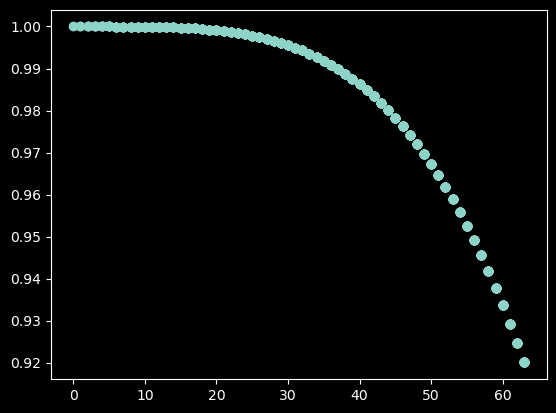

In [296]:
plt.plot(B.indxn,B.hyperdiff_fact,'o')

<Figure size 640x480 with 0 Axes>

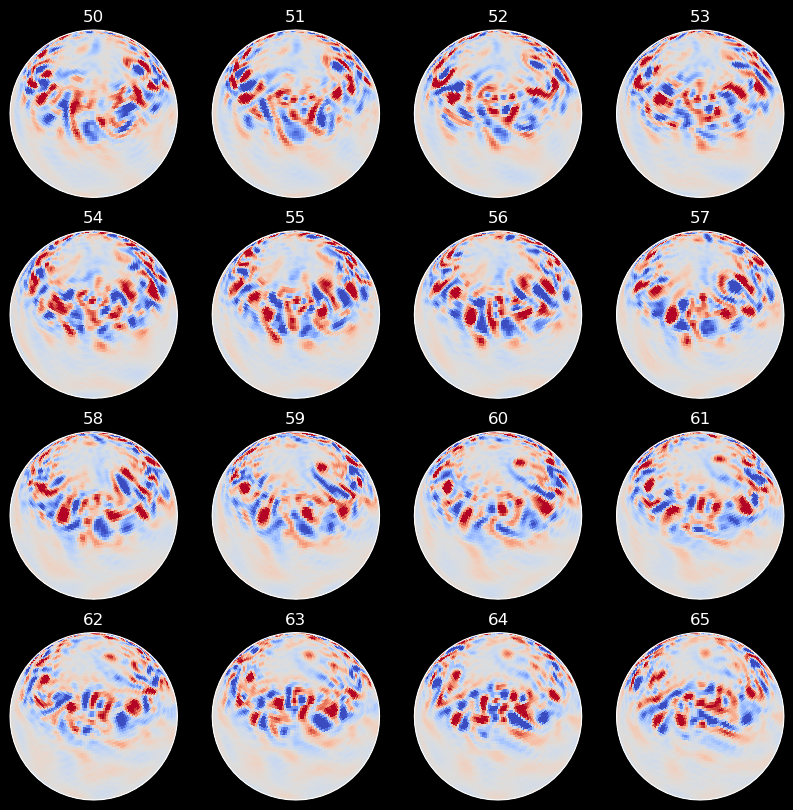

In [297]:

# look at some sample data to make sure things are working 
plt.clf()
plt.figure(0,figsize=(10,10),dpi=100)
lim=5e-5
crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=0)
for i in range(0,16):
    ind=200+i*4
    ax=plt.subplot(4,4,i+1,projection=ccrs.Orthographic(0, -45))
    ax.pcolormesh(B.lons1,B.lats1,vrt[ind],
    vmin=-0.5e-4,vmax=0.5e-4,cmap=plt.cm.coolwarm,
    transform=crs)    
    plt.title(int((dN_snap*B.dt*ind)/(3600*24)))
#    plt.title(1+i*0.5)
#    plt.yticks([])
#    plt.xticks([])
#    plt.ylim([-90,90])
#plt.savefig('test0.png')

/home/rfajber/m3/envs/pyspharm/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in subtract
  u, v = self.projection.transform_vectors(t, x, y, u, v)


<Figure size 640x480 with 0 Axes>

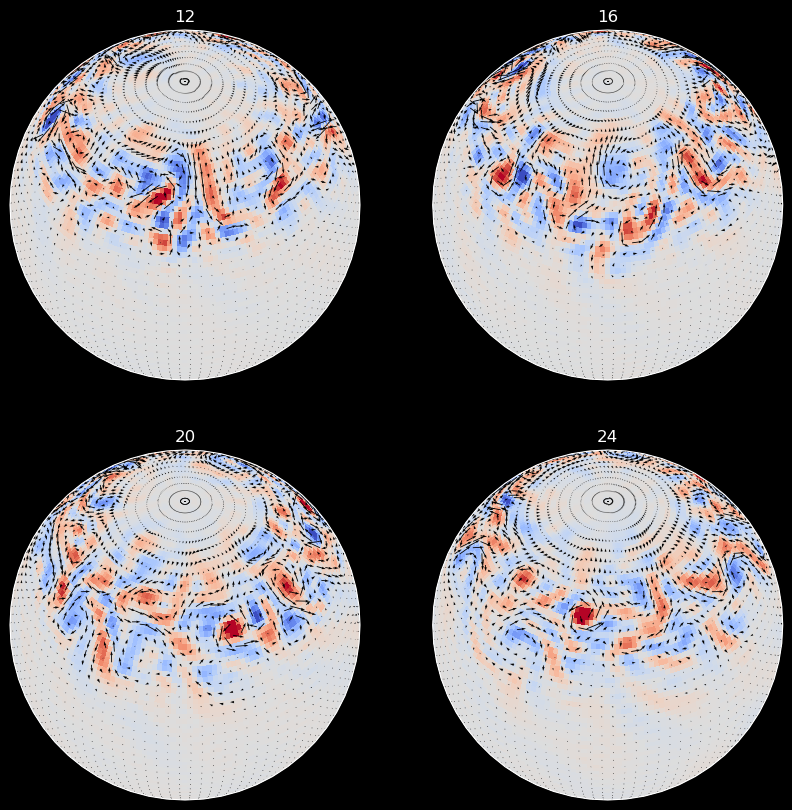

In [298]:
plt.clf()
plt.figure(0,figsize=(10,10),dpi=100)
lim=5e-5
crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=0)
nx=2; ny=2
for i in range(0,4):
    ind=48+i*16

    ax=plt.subplot(2,2,i+1,projection=ccrs.Orthographic(0, -45))
    
    
    u,v=B.x.getuv(B.x.grdtospec(vrt[ind],B.ntrunc),0*B.indxn)

    
    plt.pcolormesh(B.lons1,B.lats1,vrt[ind],
    vmin=-1e-4,vmax=1e-4,
#    levels=np.linspace(-5e-4,5e-4,21),
    cmap=plt.cm.coolwarm,
    transform=crs)    
    
    ax.quiver(B.lons[::ny,::nx],B.lats[::ny,::nx],u[::ny,::nx],v[::ny,::nx],
    color='k',
    #vmin=-0.5e-4,vmax=0.5e-4,cmap=plt.cm.coolwarm,
    transform=crs)    


    plt.title(int((dN_snap*B.dt*ind)/(3600*24)))
#    plt.title(1+i*0.5)
#    plt.yticks([])
#    plt.xticks([])
#    plt.ylim([-90,90])
#plt.savefig('test0.png')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<Figure size 640x480 with 0 Axes>

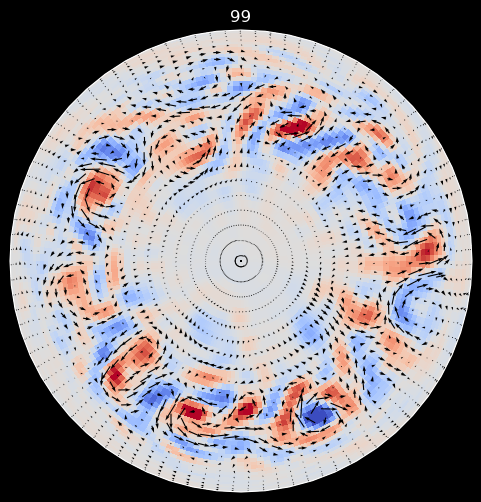

In [300]:
lim=5e-5
crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=0)
nx=2; ny=2
for i in range(0,100):
    print(i)
    plt.clf()
    plt.figure(0,figsize=(6,6),dpi=100)

    ind=300+i

    ax=plt.subplot(1,1,1,projection=ccrs.Orthographic(0, 0))
    
    
    u,v=B.x.getuv(B.x.grdtospec(vrt[ind],B.ntrunc),0*B.indxn)

    
    plt.pcolormesh(B.lons1,B.lats1,vrt[ind],
    vmin=-1e-4,vmax=1e-4,
#    levels=np.linspace(-5e-4,5e-4,21),
    cmap=plt.cm.coolwarm,
    transform=crs)    
    
    ax.quiver(B.lons[::ny,::nx],B.lats[::ny,::nx],u[::ny,::nx],v[::ny,::nx],
    color='k',
    #vmin=-0.5e-4,vmax=0.5e-4,cmap=plt.cm.coolwarm,
    transform=crs)    


    plt.title(int((dN_snap*B.dt*ind)/(3600*24)))
#    plt.title(1+i*0.5)
#    plt.yticks([])
#    plt.xticks([])
#    plt.ylim([-90,90])
    plt.savefig(f'w_{str(i).zfill(3)}.png')